<a href="https://colab.research.google.com/github/MicheleGiambelli/PlotTwisters-Project/blob/main/Transformer_funzionante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading of required libraries**

In [1]:
import pandas as pd
import numpy as np
import string
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install transformers datasets evaluate
!pip install transformers datasets evaluate seqeval

import os


from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, pipeline
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datasets import Dataset, DatasetDict
import evaluate
from sklearn.model_selection import train_test_split

import spacy
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import networkx as nx
from PIL import Image
import random
from itertools import combinations
from scipy.interpolate import make_interp_spline
from numpy.random import seed



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  

# **Loading data**

In the following are read text rows containing tokens and NER tags, assigning a unique ID to each sentence. We remove empty or invalid rows, concatenating the data into a single clean DataFrame and convert IDs to integers, preparing the dataset for later processing.

In [2]:
def file_to_dataframe(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()  # Leggi tutte le righe del file
        for i, line in enumerate(lines):
            line = line.strip()  # Rimuove spazi e newline extra
            if not line:  # Linea vuota, segna come fine frase
                data.append(("end", "end"))
                continue

            # Controlla se la riga contiene '\t' per separare token e tag
            if '\t' in line:
                parts = line.split('\t')
                if len(parts) == 2:  # La riga è valida con 2 parti
                    token, ner_tag = parts
                    data.append((token, ner_tag))
                else:  # Riga malformata
                    print(f"Riga malformata alla linea {i + 1}: {line}")
            else:  # Riga senza '\t'
                print(f"Riga senza tabulazione alla linea {i + 1}: {line}")
                # data.append(("end", "end"))

    return pd.DataFrame(data, columns=['token', 'ner_tag'])

# Converte entrambi i file in DataFrame
df1 = file_to_dataframe('sample_data/file5.txt')
df2 = file_to_dataframe('sample_data/file5.txt')


#Assegna id di frase a file6
sentence_id = 0
for idx, row in df1.iterrows():
  df1.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1

for idx, row in df2.iterrows():
  df2.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1


df1 = df1[df1["ner_tag"] != "end"]
df2 = df2[df2["ner_tag"] != "end"]

combined_df = pd.concat([df1, df2], ignore_index=True)

# Convertire la colonna id da float a int
combined_df['id'] = combined_df['id'].astype(int)


combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True) # con questo medodo possiamo rimuovere le righe del dataframe il cui valore è mancante

# Verifichiamo la presenza di righe vuote (serve più avanti per un problema al codice altrimenti)
invalid_tokens = combined_df[~combined_df['token'].apply(lambda x: isinstance(x, str))]

# Eliminare le righe con valori non stringa nella colonna 'token'
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

We used ***SpaCy*** with the pre-trained *en_core_web_sm* template to identify and remove stopwords and punctuation (except @) from the dataset. We implemented a function to clean tokens, remove empty rows, retweets (“rt”) and non-string values.

In [3]:
# Modello di lingua inglese di Spacy
nlp = spacy.load('en_core_web_sm')  # en_core_web_sm è un modello pre addestrato di spacy (small model).
stopwords = nlp.Defaults.stop_words
# Punteggiatura da rimuovere eslusa @
punctuation = set(string.punctuation) - {'@'}

# Funzione per eliminare stopwords e punteggiatura
def remove_stopwords_and_punctuation(df):
    df['token_cleaned'] = df['token'].apply(lambda x: x if x.lower() not in stopwords and x not in punctuation else '') # se è un carattere da rimuovere si crea riga vuota
    df = df[df['token_cleaned'] != '']  # Rimuove le righe con token vuoti
    return df.drop(columns=['token']).rename(columns={'token_cleaned': 'token'}) # si toglie la vecchia colonna "token" e si cambia il nome della nuova colonna "toen_cleaned" con "token"

# Applicare la funzione al dataset combinato
combined_df = remove_stopwords_and_punctuation(combined_df)

# Elimina le righe in cui il token è "rt"
combined_df = combined_df[combined_df['token'] != 'rt']  # "rt" sta per retweet

# Reset dell'indice per un DataFrame pulito (siccome prima abbiamo eliminato righe)
combined_df.reset_index(drop=True, inplace=True)

# Rimuovere eventuali NaN o valori non stringa nella colonna "token"
combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True)
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True) # manteniamo solo i valori stringa e togliamo il resto

Let's now divide our *combine_df* into *training* (70%), *test* (10% ) and *validation* (20%) such that *tokens* with the same sentence *id* shall remain in the same order and in the same dataset.

In [4]:
# Dividere il dataset in train, validation e test
unique_ids = combined_df['id'].unique()
# seed(42) inutile perchè abbiamo già random_state=42 alla riga sotto
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42).values
train_ids, temp_ids = train_test_split(shuffled_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)
train_df = combined_df[combined_df['id'].isin(train_ids)]
val_df = combined_df[combined_df['id'].isin(val_ids)]
test_df = combined_df[combined_df['id'].isin(test_ids)]

# **NER-TAG Classification with Transformers**

We defined a path so that we could save the model later (in case we were not using Google Colab).

In [5]:
# Per salvataggio modello (codice datato, più avanti lo miglioro, non lo tolgo altrimenti devo fare fine-tuning di nuovo)
save_directory = r'C:\Users\capel\OneDrive\Desktop\Data Visualization and Text Mining\Assignment'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

To prevent the occurrence of a request for an authentication API key to wandb we wrote this line of code.     

In [6]:
# Disabilitare wandb per evitare richieste di API key
os.environ["WANDB_DISABLED"] = "true"   # Disabilitare wandb (Weights and Biases): evita richieste di autenticazione a Weights and Biases, uno strumento di monitoraggio delle esperienze di machine learning.


## **Mapping NER labels to unique IDs**


After identifying all unique NER labels in the data we created two map dictionaries:
- ***tag2id***: associates each NER label with a unique numeric ID
- ***id2tag***: this does the reverse (numeric ID to NER label).
Finally, we apply the tag2id mapping to the three datasets thereby replacing the NER labels with their respective numeric IDs to make the data compatible with the *Hugging* *Face* model.

In [7]:
# step 1: Mappare le etichette NER a ID unici
all_df = pd.concat([train_df, val_df, test_df])                     # si poteva utilizzare direttamente combined_df
unique_tags = all_df['ner_tag'].unique().tolist()                   # .tolist() converte l'array NumPy restituito da .unique() in una lista Python.
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}          # dizionario in cui la chiave è il NER e il valore è un numero
id2tag = {idx: tag for tag, idx in tag2id.items()}                  # viceversa
train_df['ner_tag_id'] = train_df['ner_tag'].map(tag2id)            # ogni NER viene sostituito dal corrispondente id numerico presente nel dizionario tag2id
val_df['ner_tag_id'] = val_df['ner_tag'].map(tag2id)
test_df['ner_tag_id'] = test_df['ner_tag'].map(tag2id)

## **Preparing Data for Hugging Face**


The multiple datasets are reorganized using Pandas *groupby*. The data are grouped by sentence by ID, aggregating tokens and NER numeric labels into lists. This format is required for Hugging Face, since models like BERT work on sentence-level input. In the end, we get three DataFrames (train, val, test), each with one row per complete sentence and its columns with associated tokens and tags.

In [8]:
####   *step 2: Preparare i dati per Hugging Face**  ########

# Raggruppare i token e le etichette per frase utilizzando 'id' come identificatore siccome  modelli tipo BERT operano su frasi complete.
def group_data(df):
    return df.groupby('id').agg({'token': list, 'ner_tag_id': list}).reset_index()

train_dataset = group_data(train_df)
val_dataset = group_data(val_df)
test_dataset = group_data(test_df)

## **Ensuring the proper alignment between tokens and labels**

To be on the safe side, we double checked that the previous step was successful i.e., we checked that the number of tokens and NER labels for each phrase in the three datasets are aligned. The function uses *.str.len()* from Pandas to compare the length of the token lists and labels in each row of the DataFrame. If there are mismatches, the problematic sentences will be printed, otherwise the check passes successfully.

In [9]:
####   **step 3: Verificare l'allineamento tra token e etichette**   #####

def check_token_label_alignment(df_grouped):
    misaligned = df_grouped[
        df_grouped['token'].str.len() != df_grouped['ner_tag_id'].str.len()
    ]
    if not misaligned.empty:
        print("Frasi con disallineamento tra token e etichette:")
        print(misaligned)
    return misaligned.empty

assert check_token_label_alignment(train_dataset), "Disallineamento nel train set"
assert check_token_label_alignment(val_dataset), "Disallineamento nel validation set"
assert check_token_label_alignment(test_dataset), "Disallineamento nel test set"

## **Creating the datasets for Hugging Face**

Training, validation, and test datasets are converted from Pandas DataFrame format to Hugging Face's Dataset format using the *Dataset.from_pandas()* function.  Finally, the three datasets are grouped into a DatasetDict object, which organizes the data into a single structure, facilitating access and integration with the Hugging Face API.

In [10]:
####    *step 4: Creare i dataset per Hugging Face*    #####

train_dataset = Dataset.from_pandas(train_dataset)  # siccome hugging face utilizza specifici formati utilizziamo "Dataset" per convertire un DataFrame Pandas in un formato compatibile
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

datasets = DatasetDict({   # raggruppiamo tutto insieme per facilita l'uso delle API di hugging face.
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

## **Loading the tokenizer and the pre-trained model**

- **Pre-trained model**: The model selected is “***distilbert-base-cased***,” a lightweight version of BERT (Bidirectional Encoder Representations from Transformers) designed to be faster and less memory-intensive than the full BERT. It is case-sensitive.

- **Tokenizer**: The ***AutoTokenizer.from_pretrained()*** function automatically loads the tokenizer associated with the pre-trained template.
The tokenizer is responsible for splitting the text into tokens and mapping them to numeric IDs compatible with the template. It also handles the addition of special tokens (e.g., [CLS], [SEP]) and padding/truncation.

- **Purpose**: The pre-trained model serves as the base and is adapted (fine-tuned) to the specific data of our NER project.

Some additional information on ***distilbert-base-cased*** can be found at the following link:

 https://huggingface.co/distilbert/distilbert-base-cased


Below we cite some of the features of the model.
- Distillation loss: the model was trained to return the same probabilities as the BERT base model.
- Masked language modeling (MLM): this is part of the original training loss of the BERT base model. When taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. This is different from traditional recurrent neural networks (RNNs) that usually see the words one after the other, or from autoregressive models like GPT which internally mask the future tokens. It allows the model to learn a bidirectional representation of the sentence.
- Cosine embedding loss: the model was also trained to generate hidden states as close as possible as the BERT base model.

- Even if the training data used for this model could be characterized as fairly neutral, this model can have biased predictions. It also inherits some of the bias of its teacher model.
- DistilBERT pretrained on the same data as BERT, which is BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers).
- Small size: DistilBERT has about 40 percent fewer parameters than basic BERT.
- Performance: Despite being smaller, DistilBERT maintains about 97% of BERT's performance on several NLP benchmarks.
- Advantages:
  1. Computational efficiency:Requires less memory and computational resources.
  2. Speed: Faster during both training and inference.
  3. Suitable for resource-limited environments: Ideal for applications that need lightweight models.


In [11]:
####  **step 5: Caricare il tokenizer e il modello pre-addestrato**  #######

model_name = "distilbert-base-cased"                   # Modello leggero e case-sensitive
tokenizer = AutoTokenizer.from_pretrained(model_name)  # AutoModelForTokenClassification è il modello pre-addestrato, configurato per il task di token classification (NER).
model = AutoModelForTokenClassification.from_pretrained(
    model_name, num_labels=len(tag2id)                 # specificare il numero di token unici con num_labels=len(tag2id)
)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Tokenization and label alignment**

The *tokenize_and_align_labels* function tokenizes sequences using the Hugging Face tokenizer, maintaining alignment between generated tokens and NER labels. Main tokens retain their original labels, while special tokens and sub-tokens are ignored by assigning -100. Tokenization includes padding to equalize sequences to a maximum length of 65 tokens. The function is applied to the datasets using *datasets.map()*, removing unnecessary columns and producing training-ready datasets.

In [12]:
####   **step 6: Tokenizzazione e allineamento delle etichette**   ######

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['token'],
        is_split_into_words=True,  # token già divisi in parole (e non frasi)
        truncation=True,           # troncare token che superano la lunghezza massima (non ci dovrebbero essere token da 65 in ogni caso)
        padding='max_length',      # ricordarsi: il padding è una tecnica utilizzata per gestire input di lunghezza differente. aggiunge token speciali ([PAD]) alle sequenze più corte per uniformarne la lunghezza.
        max_length=28              # Lunghezza massima pari a 28
    )

    labels = []
    for i, label in enumerate(examples['ner_tag_id']):
        word_ids = tokenized_inputs.word_ids(batch_index=i) # restituisce None per i token speciali come [PAD], [CLS] e [SEP]
                                                            # ogni elemento della lista rappresenta l'indice della parola originale a cui il token appartiene oppure None
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:                   # si controlla token speciali tipo [CLS], [SEP] e nel caso gli si assegna un etichetta particolare per ignorarli
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # Token principali
            else:                                  # Gestisce i sotto-token, cioè i token che appartengono alla stessa parola (per sicurezza)
                label_ids.append(-100)             # Sotto-token
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Applicare la tokenizzazione ai dataset
print("Tokenizzazione in corso...")
tokenized_datasets = datasets.map(
    tokenize_and_align_labels,                    # è la funzione definita prima
    batched=True,                                 # più frasi in contemporanea
    remove_columns=['id', 'token', 'ner_tag_id']
)


Tokenizzazione in corso...


Map:   0%|          | 0/2993 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

## **Preparing for training**

**Data Collator**: Hugging Face's *DataCollatorForTokenClassification* is used to handle dynamic padding during batch creation. This ensures that all sequences in a batch have the same length as the longest token, improving efficiency and memory management. testo in corsivo

We also computed some metrics to evaluate model performance. This is done by converting probabilistic model predictions to final labels using *np.argmax*.
Excluding tokens with -100 label to focus only on relevant tokens.
To compute the metrix we used ***seqeval***  that is specific for NER tasks; the metrixs are:
- Precision: Percentage of correct entities among those predicted.
- Recall: Percentage of correct entities among those present.
- F1-Score: Harmonic mean between precision and recall.
- Accuracy: Percentage of tokens classified correctly.


In [13]:
### **step 7: Preparare per l'addestramento**  ######

data_collator = DataCollatorForTokenClassification(tokenizer)  # Data Collator: gestisce il padding dinamico durante la creazione dei batch, in modo che ogni batch sia della stessa lunghezza del token più lungo presente. Questo aumenta l'efficienza e la gestione della memoria.

# Definire la funzione per calcolare le metriche
def compute_metrics(p):
    predictions, labels = p                                    # Rappresenta le predizioni del modello e le etichette vere
    predictions = np.argmax(predictions, axis=2)               # Converte le predizioni probabilistiche del modello in etichette finali

    true_predictions = [
        [id2tag[pred] for (pred, label_id) in zip(prediction, label) if label_id != -100]    # escludiamo i lable -100 ovvero caratteri speciali
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[label_id] for (pred, label_id) in zip(prediction, label) if label_id != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Sequeval per il calcolo delle metriche
    seqeval = evaluate.load("seqeval")                       # SEQUEVAL:  è una libreria Python progettata per calcolare metriche di valutazione per il NER.
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results.get("overall_precision", 0.0),  #  Percentuale di entità rilevate correttamente rispetto a tutte quelle predette.
        "recall": results.get("overall_recall", 0.0),        # Percentuale di entità rilevate correttamente rispetto a tutte quelle effettivamente presenti.
        "f1": results.get("overall_f1", 0.0),                # Media armonica tra precisione e richiamo
        "accuracy": results.get("overall_accuracy", 0.0),    # Percentuale di token classificati correttamente (nel validation)

    }

## **Setting the training parameters**

We defined the training parameters using ***TrainingArguments*** from Hugging Face. Among them, we specified:

- The directory where we want to save the model.
- The number of training epochs (3).
- The batch size for both training and evaluation.
- The evaluation and saving strategy (at each epoch).
- The logging every 50 steps to monitor progress.
- The automatic loading of the best model at the end of training.
- The use of mixed-precision calculations (FP16) if we have a GPU with CUDA support, to optimize performance and memory.

In [14]:
##    **step 8: Impostare i parametri di addestramento* ######à

training_args = TrainingArguments(
    output_dir=save_directory,        # Directory in cui vorrei salvare il modello (definita in precedenza)
    num_train_epochs=3,               # il modello farà 3 volte il giro del trainig set
    per_device_train_batch_size=32,   # numero di campioni processati in parallelo durante l'addestramento e la valutazione.
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",      # valutare il modello al termine di ogni epoca
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50,                # Specifica dove salvare i log e ogni quanti step loggare le informazioni di addestramento (50 dovrebbe essere la prassi)
    load_best_model_at_end=True,     # Dopo l'addestramento, carica automaticamente il modello con le migliori prestazioni sulla validation set
    report_to="none",
    fp16=torch.cuda.is_available(),  # Utilizza calcoli a precisione mista (FP16) se una GPU con supporto CUDA è disponibile, per migliorare la velocità e ridurre il consumo di memoria.
)


## **Creating the trainer**

We created a trainer using Hugging Face's ***Trainer*** class, which simplifies model training and evaluation. Specifically:

- We passed the pre-trained model and previously defined training parameters.
- We specified the already tokenized training and validation datasets.
- The *tokenizer* and *data_collator* are used to properly handle batch and padding.
- The *compute_metrics* function computes evaluation metrics specific to the NER task.
- The trainer handles loss automatically, excluding tokens with a -100 label (like padding), making the training process more efficient.

In [15]:
#####  **step 9: Creare il trainer**  ######

trainer = Trainer(                                    # "Trainer" in hugging face che include una variante della Cross Entropy Loss la quale ignora automaticamente i token con etichetta -100 (quindi ad esempio i padding)
    model=model,                                      # modello pre addestrato
    args=training_args,
    train_dataset=tokenized_datasets['train'],        # TRAINING SET UTILIZZATO QUI, ricordarsi che contiene sequenze di stringe e -100
    eval_dataset=tokenized_datasets['validation'],    # VALIDATION SET UTILIZZATO QUI
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

## **Initiating training**

We started training the model using the ***.train()*** method of the Trainer. This step uses the previously defined parameters, the tokenized datasets, and the pre-trained model. During training, the trainer automatically handles batch splitting, loss calculation and optimization, recording progress and saving the best model at the end of each epoch.

In [16]:
###  step 10: Avviare l'addestramento  ###

print("Inizio dell'addestramento...")
trainer.train()

Inizio dell'addestramento...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.730300,0.196288,0.797035,0.780134,0.788494,0.934283
2,0.148700,0.129287,0.866444,0.868862,0.867651,0.959301
3,0.075900,0.116351,0.887715,0.891183,0.889446,0.965286


TrainOutput(global_step=282, training_loss=0.24339807033538818, metrics={'train_runtime': 54.3803, 'train_samples_per_second': 165.115, 'train_steps_per_second': 5.186, 'total_flos': 64161575827272.0, 'train_loss': 0.24339807033538818, 'epoch': 3.0})

**Metrics by Epoch during Training**:
In the table, we can see the progress of the model in terms of loss and evaluation metrics during the three training epochs.

1. **Training Loss and Validation Loss**:

Training Loss and Validation Loss progressively decrease for each epoch. This indicates that the model is improving its ability to learn patterns from the data, reducing both the error on the training data and the error on the validation data. A consistent decrease in Validation Loss suggests that the model is not overfitting, but is generalizing well on unseen data.

2. **Precision, Recall, F1, and Accuracy**:

- Precision: Represents the percentage of correct predictions among all predictions made. We see that precision improves from 0.802 in the first epoch to 0.889 in the third epoch.

- Recall: It indicates the percentage of correct entities that the model was able to detect. Recall also increases from 0.765 to 0.898, indicating that the model was able to recognize more entities correctly as training progressed.

- F1 Score: The harmonic mean of precision and recall, representing a good compromise between the two metrics.

- Accuracy: The overall Accuracy goes up showing a steady increase in the accuracy of the model.

Overall, we can see that the values of all metrics improve during the three epochs, indicating that the model was able to learn and improve effectively.

## **Saving the model**

Below we have given the option of saving the model in two different ways depending on whether you use Colab or visual studio code.

In [29]:
#### **step 12: Salvare il modello addestrato**  ####

#questo codice è utile per salvare il modello sul pc se non si sta usando colab
#trainer.save_model(save_directory)
#tokenizer.save_pretrained(save_directory)


####### SALVARE IL MODELLO  sul drive  #######

from google.colab import drive
drive.mount('/content/drive')

save_directory = '/content/drive/MyDrive/Assignment'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"Modello e tokenizer salvati correttamente nella directory: {save_directory}")

Mounted at /content/drive
Modello e tokenizer salvati correttamente nella directory: /content/drive/MyDrive/Assignment


## **Appraising the fine-tuned model on the various sets**

We wanted to evaluate the performance of the model on the validation and test datasets using the *.evaluate()* method.

In detail:

- Evaluation on the validation set: We computed metrics to monitor how the model performs on unseen data during training.
- Evaluation on the test set: We computed the final metrics to measure the overall performance of the model.

We collected the key metrics (loss, precision, recall, F1-score, and accuracy) and organized them in a Pandas DataFrame for clear visualization. This allows us to easily compare the results between the validation set and the test set.

In [33]:
#### step 11: Valutare il modello sui vari set  ####

# Specifica la directory dove abbiamo salvato il modello
save_directory = '/content/drive/MyDrive/Assignment'

# Carica il modello fine-tunato
model_fine_tuned = AutoModelForTokenClassification.from_pretrained(save_directory)

# Crea un Trainer per il modello fine-tunato
trainer_fine_tuned = Trainer(
    model=model_fine_tuned,  # Modello fine-tunato
    args=training_args,      # Argomenti di addestramento già definiti
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Valutare il modello fine-tunato sul set di validazione
print("Valutazione del modello fine-tunato sul validation set...")
validation_metrics_fine_tuned = trainer_fine_tuned.evaluate(tokenized_datasets['validation'])
print("Metriche sul validation set (modello fine-tunato):")
print(validation_metrics_fine_tuned)

# Valutare il modello fine-tunato sul set di test
print("Valutazione del modello fine-tunato sul test set...")
test_metrics_fine_tuned = trainer_fine_tuned.evaluate(tokenized_datasets['test'])
print("Metriche sul test set (modello fine-tunato):")
print(test_metrics_fine_tuned)

# Raccolta metriche
data_fine_tuned = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics_fine_tuned['eval_loss'], test_metrics_fine_tuned['eval_loss']],
    "Precision": [validation_metrics_fine_tuned.get('eval_precision', 0.0), test_metrics_fine_tuned.get('eval_precision', 0.0)],
    "Recall": [validation_metrics_fine_tuned.get('eval_recall', 0.0), test_metrics_fine_tuned.get('eval_recall', 0.0)],
    "F1": [validation_metrics_fine_tuned.get('eval_f1', 0.0), test_metrics_fine_tuned.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics_fine_tuned.get('eval_accuracy', 0.0), test_metrics_fine_tuned.get('eval_accuracy', 0.0)]
}

# Creazione di un DataFrame Pandas per creare tabella leggibile
metrics_df_fine_tuned = pd.DataFrame(data_fine_tuned)
print("\nTabella riassuntiva delle metriche per il modello fine-tunato:")
print(metrics_df_fine_tuned)


Valutazione del modello fine-tunato sul validation set...


Metriche sul validation set (modello fine-tunato):
{'eval_loss': 0.11635075509548187, 'eval_model_preparation_time': 0.002, 'eval_precision': 0.8877153974430239, 'eval_recall': 0.8911830357142857, 'eval_f1': 0.8894458368142579, 'eval_accuracy': 0.965286090495571, 'eval_runtime': 1.945, 'eval_samples_per_second': 439.58, 'eval_steps_per_second': 13.881}
Valutazione del modello fine-tunato sul test set...
Metriche sul test set (modello fine-tunato):
{'eval_loss': 0.10885792970657349, 'eval_model_preparation_time': 0.002, 'eval_precision': 0.8926096997690531, 'eval_recall': 0.8926096997690531, 'eval_f1': 0.8926096997690531, 'eval_accuracy': 0.9658140090843892, 'eval_runtime': 1.859, 'eval_samples_per_second': 230.234, 'eval_steps_per_second': 7.531}

Tabella riassuntiva delle metriche per il modello fine-tunato:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.116351   0.887715  0.891183  0.889446  0.965286
1        Test  0.108858   0.892610  0.892610  0.8

## **Summary Table of Metrics for Validation and Testing**

In the table, metrics calculated on the validation and test sets after the completion of the three training epochs are represented.

***Validation Set:*** The values suggest that the model was able to generalize quite well, with good precision and recall.


***Test Set:***  Values very similar to validation.


Overall Interpretation:
- In general, we observe that the model shows good results on both validation and test data. The relatively high accuracy and F1 score suggest that the model has learned to recognize named entities reliably and that the risk of overfitting is low.
- The relatively high Recall compared to Precision suggests that the model is rather “inclusive,” trying to identify most entities, although this means that it may occasionally make less accurate predictions (i.e., predict an entity where there is none).
- Consistency between validation and test metrics is a good sign, indicating that the model has sufficient generalization ability on data never seen before, without having learned too specific patterns of the training set.

## **Evaluation of the non-fine-tuned model**

We also decided to evaluate the non-fine-tuned model in order to compare the two.

In [26]:
# Creazione di un Trainer per il modello non fine-tunato
trainer_non_tuned = Trainer(
    model=model,  # Questo è il modello non fine-tunato già inizializzato in precedenza
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train'],
    compute_metrics=compute_metrics,
    eval_dataset=tokenized_datasets['validation']  # Assicurati di passare il dataset di validazione
)

# Valutazione del modello non fine-tunato sul set di validazione
print("Valutazione del modello non fine-tunato sul validation set...")
validation_metrics_non_tuned = trainer_non_tuned.evaluate()
print("Metriche del modello non fine-tunato sul validation set:")
print(validation_metrics_non_tuned)

# Valutazione del modello non fine-tunato sul set di test
trainer_non_tuned.eval_dataset = tokenized_datasets['test']  # Cambia il dataset di valutazione al test set
print("Valutazione del modello non fine-tunato sul test set...")
test_metrics_non_tuned = trainer_non_tuned.evaluate()
print("Metriche del modello non fine-tunato sul test set:")
print(test_metrics_non_tuned)

# Raccolta metriche in formato tabellare
data_non_tuned = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics_non_tuned['eval_loss'], test_metrics_non_tuned['eval_loss']],
    "Precision": [validation_metrics_non_tuned.get('eval_precision', 0.0), test_metrics_non_tuned.get('eval_precision', 0.0)],
    "Recall": [validation_metrics_non_tuned.get('eval_recall', 0.0), test_metrics_non_tuned.get('eval_recall', 0.0)],
    "F1": [validation_metrics_non_tuned.get('eval_f1', 0.0), test_metrics_non_tuned.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics_non_tuned.get('eval_accuracy', 0.0), test_metrics_non_tuned.get('eval_accuracy', 0.0)]
}

# Creazione di un DataFrame Pandas per le metriche
metrics_df_non_tuned = pd.DataFrame(data_non_tuned)

# Stampa della tabella
print("\nTabella riassuntiva delle metriche per il modello non fine-tunato:")
print(metrics_df_non_tuned)


Valutazione del modello non fine-tunato sul validation set...


Metriche del modello non fine-tunato sul validation set:
{'eval_loss': 0.11635075509548187, 'eval_model_preparation_time': 0.0085, 'eval_precision': 0.8877153974430239, 'eval_recall': 0.8911830357142857, 'eval_f1': 0.8894458368142579, 'eval_accuracy': 0.965286090495571, 'eval_runtime': 2.6757, 'eval_samples_per_second': 319.543, 'eval_steps_per_second': 10.091}
Valutazione del modello non fine-tunato sul test set...
Metriche del modello non fine-tunato sul test set:
{'eval_loss': 0.10885792970657349, 'eval_model_preparation_time': 0.0085, 'eval_precision': 0.8926096997690531, 'eval_recall': 0.8926096997690531, 'eval_f1': 0.8926096997690531, 'eval_accuracy': 0.9658140090843892, 'eval_runtime': 1.9853, 'eval_samples_per_second': 215.587, 'eval_steps_per_second': 7.052}

Tabella riassuntiva delle metriche per il modello non fine-tunato:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.116351   0.887715  0.891183  0.889446  0.965286
1        Test  0.108858 

The identical metrics obtained between the pre-trained and fine-tuned models can be explained by several factors related to the quality of the base model and the nature of our dataset.

The pre-trained model, in this case DistilBERT, has been trained on very large datasets, such as Wikipedia and book corpora, and is already optimized for a wide range of NLP tasks, including those similar to entity recognition. This broad knowledge base allows the model to achieve very robust results even without further adaptation.

In addition, our dataset counts a small amount compared to the billions of tokens on which the model was originally trained. This may limit the impact of fine-tuning, as the new data may not be sufficient to further “specialize” the model significantly.

Finally, considering that the model was designed to perform well on similar classification tasks, and our task may be in line with already learned data distributions, it is likely that the model does not need further adjustment to achieve optimal results.

In summary, the pre-trained model is already highly performing on our dataset, which justifies the identical metrics between the two scenarios. This result highlights how, in some cases, fine-tuning may not bring obvious benefits when the model is already well optimized for the task at hand.


This result can also be seen visually from the following graphs:

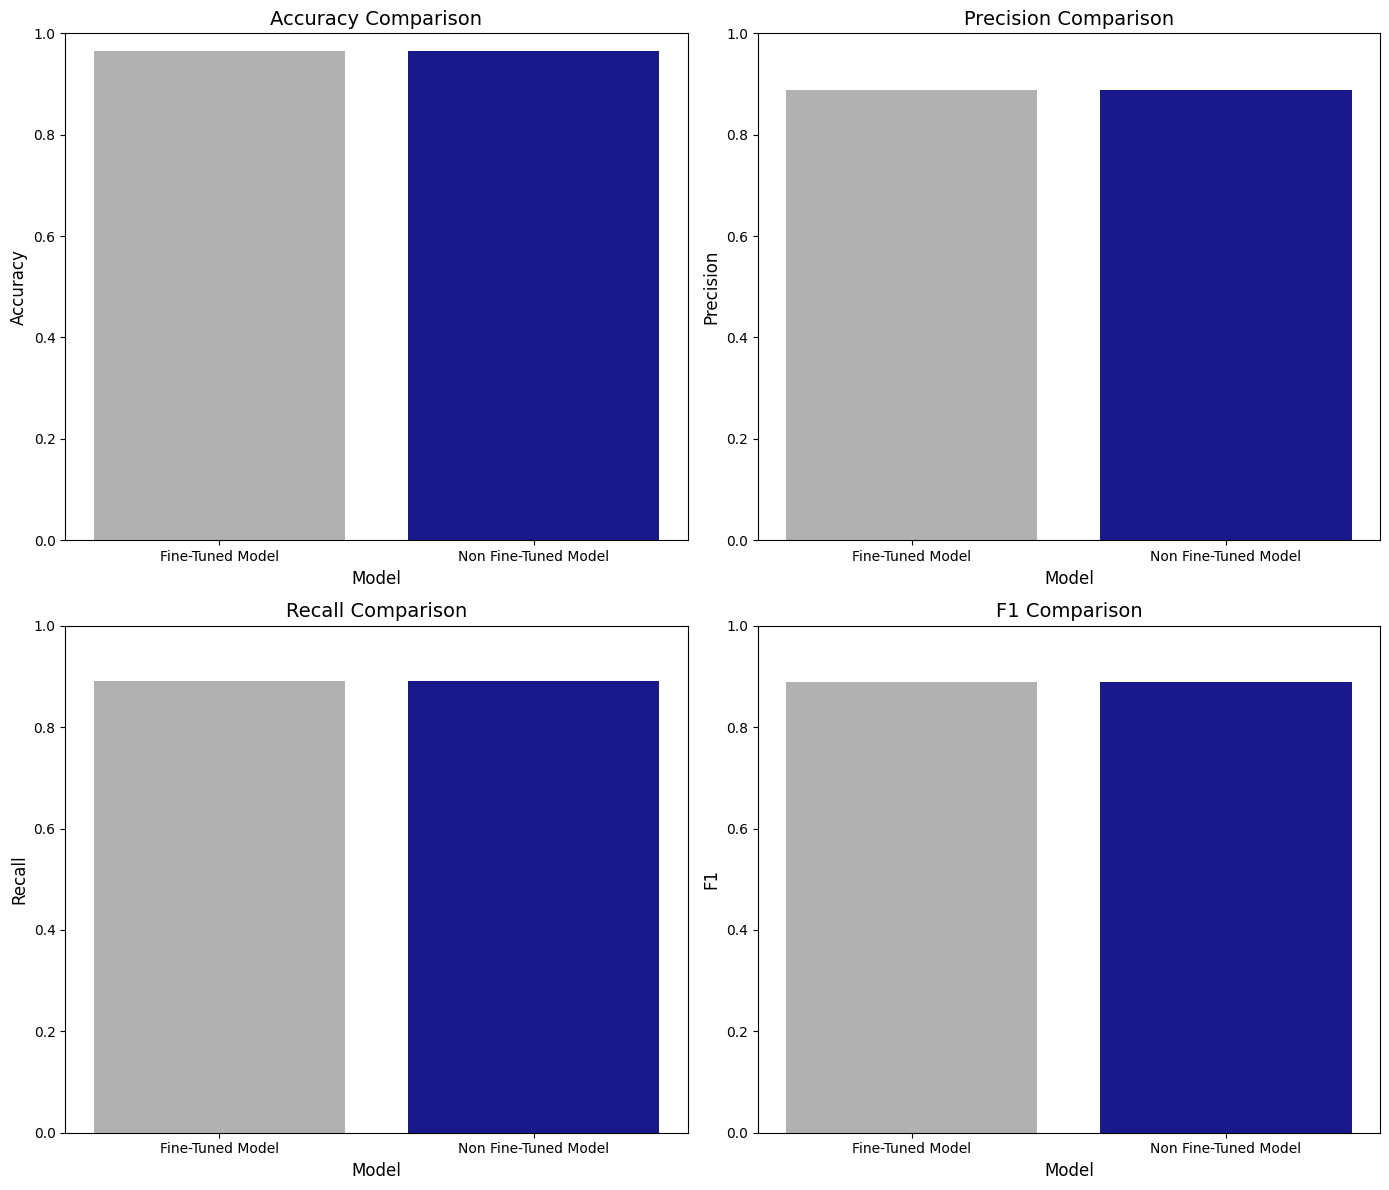

In [39]:
# Creare una griglia di 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # Converte la matrice degli assi in un array per un accesso più semplice

bar_colors = ["darkgray", "navy"]

# Creare i grafici
for ax, metric in zip(axes, metrics_df.columns):
    ax.bar(metrics_df.index, metrics_df[metric], color=bar_colors, alpha=0.9)
    ax.set_title(f"{metric.capitalize()} Comparison", fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.set_xlabel("Model", fontsize=12)

    # Rimuove la griglia dall'asse y per evitare le righe orizzontali
    ax.grid(False)

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Nascondere gli assi vuoti se ci sono meno di 4 metriche
for ax in axes[len(metrics_df.columns):]:
    ax.axis('off')

# Adattare gli spazi
plt.tight_layout()
plt.show()


# **Testing the NER label prediction model**



We decided to test the model on ner tag predictions on both the pretrained non-fine-tuned and fine-tuned models.

Lets' start with the the pretrained fine-tuned model.  

We loaded the fine-tuned model and tokenizer from the ./sample_data directory. The predict_ner function allows us to tokenize a sentence, obtain predictions from the model, and reconstruct words with their respective NER labels, ignoring special tokens. Finally, we tested the model on novel sentences to verify its ability to correctly identify and classify entities such as proper names, places, and organizations.

In [41]:
# Specificare la directory dove sono salvati i file ("./sample_data" è la mia ad esmpio)
model_directory = "/content/drive/MyDrive/Assignment"

# Caricare il modello fine-tunato e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_directory)  # Carica il modello fine-tunato
                                                                          # config: Per configurare il modello.
                                                                          # model.safetensors: Per caricare i pesi addestrati.
                                                                          # tokenizer_config, special_tokens_map, vocab: Per configurare il tokenizer e mappare i token ai rispettivi ID
tokenizer = AutoTokenizer.from_pretrained(model_directory)                # Carica il tokenizer

# Funzione di predizione
def predict_ner(sentence):
    # Tokenizzare la frase
    inputs = tokenizer.encode_plus(
        sentence,
        return_tensors='pt',             # Restituisce l'output come tensori PyTorch
        is_split_into_words=False,       # Input è una frase completa
        truncation=True,
        max_length=65                    # Lunghezza max usata durante l'addestramento
    )
    input_ids = inputs['input_ids']

    model.eval()                         # Modello in modalità valutazione per evitare modifiche ai pesi

    # Ottenere le predizioni
    with torch.no_grad():                # Disabilita il calcolo del gradiente
        outputs = model(**inputs)       # Si ottengono i logits
    predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()    # Per ogni token si seleziona l'indice della classe con la probabilità più alta

    # Convertire input_ids in token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Ricostruire le parole dai sub-token e assegnare le etichette
    words = []
    labels = []
    for idx, (token, pred) in enumerate(zip(tokens, predictions)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
        if token.startswith('##'):
            words[-1] += token[2:]
        else:
            words.append(token)
            labels.append(id2tag[pred])

    # Stampare le parole e le relative etichette
    print("\nPredizione:")
    print("Parola\tEtichetta")
    for word, label in zip(words, labels):
        print(f"{word}\t{label}")


print("\nEsempio di predizione:")
test_sentence = "let's see if the predictions of @Plottwisters are correct and look if Emma has done a great job here in milan."
predict_ner(test_sentence)
test_sentence = "Hi Emma in Milan, !!! America, Obama, Trump and NATO @Plottwister is predicting pretty well."
predict_ner(test_sentence)



Esempio di predizione:

Predizione:
Parola	Etichetta
let	O
'	O
s	O
see	O
if	O
the	O
predictions	O
of	O
@	B-PER
Plottwisters	B-PER
are	O
correct	O
and	O
look	O
if	O
Emma	B-PER
has	O
done	O
a	O
great	O
job	O
here	O
in	O
milan	B-LOC
.	O

Predizione:
Parola	Etichetta
Hi	O
Emma	B-PER
in	O
Milan	B-LOC
,	O
!	O
!	O
!	O
America	B-PER
,	O
Obama	B-PER
,	O
Trump	B-PER
and	O
NATO	B-PER
@	B-PER
Plottwister	B-PER
is	O
predicting	O
pretty	O
well	O
.	O


We then used the same approach for the non-fine-tuned model

In [42]:
####  TESTIAMO IL MODELLO  (ma sul modello di hugging face e non sul modello fine-tunato, dopo lo farò pure su quello), è una prova   ########

def predict_ner(sentence):
    # Tokenizzare la frase (ovvero trasforma ogni parola in un ID numerico.)
    inputs = tokenizer.encode_plus(
        sentence,
        return_tensors='pt',             # Restituisce l'output come tensori PyTorch
        is_split_into_words=False,       # input è una frase cimpleta
        truncation=True,
        max_length=65                    # lunghezza max usata durante l'addestramento
    )
    input_ids = inputs['input_ids']


    model.eval()                         # modello in modalità valutazione per evitare modifiche dei pesi

    # Ottenere le predizioni
    with torch.no_grad():                # Disabilita il calcolo del gradiente
        outputs = model(input_ids)       # si ottengono i logits che sono le probabilità non normalizzate per ogni token e per ogni classe NER
                                         # qua utilizzo il modello addestrato prima
    predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()    # Per ogni token si seleziona l'indice della classe con la probabilità più alta

    # Convertire input_ids in token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Ricostruire le parole dai sub-token e assegnare le etichette
    words = []
    labels = []
    for idx, (token, pred) in enumerate(zip(tokens, predictions)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue  # Ignora token speciali
        if token.startswith('##'):
            words[-1] += token[2:]
        else:
            words.append(token)
            labels.append(id2tag[pred])

    # Stampare le parole e le relative etichette
    print("\nPredizione:")
    print("Parola\tEtichetta")
    for word, label in zip(words, labels):
        print(f"{word}\t{label}")

In [43]:
###  Esempi di predizione   ###
print("\nEsempio di predizione:")
test_sentence = "let's see if the predictions of @Plottwisters are correct and look if Emma has done a great job here in milan."
predict_ner(test_sentence)


Esempio di predizione:

Predizione:
Parola	Etichetta
let	O
'	O
s	O
see	O
if	O
the	O
predictions	O
of	O
@	B-PER
Plottwisters	B-PER
are	O
correct	O
and	O
look	O
if	O
Emma	B-PER
has	O
done	O
a	O
great	O
job	O
here	O
in	O
milan	B-LOC
.	O


We can see that both models make accurate and precise predictions.